## Notebook extracts LST from all available assets and plots for comparison.

In [2]:
import json
import requests
import pystac
from pystac_client import Client
from pprint import pprint

from botocore.exceptions import ClientError
from shapely.geometry import box, mapping, Point, Polygon

from pyproj.crs import CRS
import pandas as pd
import geopandas as gpd

import xarray as xr
import rioxarray as rxr
import rasterio as rio

from matplotlib import pyplot as plt
import numpy as np

from FH_Hydrosat import FH_StackedDataset
from FH_Hydrosat import FH_Hydrosat

import os
os.environ['USE_PYGEOS'] = '0'
import base64
from datetime import datetime
from datetime import date

/var/folders/zs/pstrmbpn6t75t6hdl9_v8_8w0000gn/T/ipykernel_45778/3725132830.py:12: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


### Cell below contains functions.  No user editing is required.

In [134]:
# ---------------------------------------------------------------------------------

def stac_tile_search(collection, geom, start_date, end_date):
    """
    Log into STAC and search for a specified image collection.
    """

    search = catalog.search(
        collections = collection,
        intersects = geom,
        datetime = [start_date, end_date],
        max_items = 500
    )

    #items = list(search.items()) # for pystac-client >= 0.4.0
    found_items = list(search.get_all_items()) # for pystac-client < 0.4.0
    found_items.reverse() # make the results ascending in time

    num_tiles = len(found_items)
    print ("colllection: {} \n".format(collection))
    print ("Number of fusion tiles available: {}".format(num_tiles))

    return (found_items, num_tiles)

# ---------------------------------------------------------------------------------

def extract_time_series(items, bbox, tol, var_name, start, end, asset):
    '''
    Uses FH_Hydrosat class method point_time_series_from_items()
    to extract only a time-series.

    Parameters:
    -----------
    items: list
        Image items returned from STAC search.
    bbox: 
        Bounding box of coordinates for seacrh site.
    tol: int
        A search parameter in meters for finding point data.
    var_name: str
        Dataframe column name for data extracted.
    asset: str
        Search parameter for type of asset to be searched.
    
    Returns:
    -------
    lst_df: dataframe
        Dataframe containing date time series.
    '''

    # Sample the LST items.
    print (asset)
    lst_res = FH_Hydrosat(items, asset=asset)

    # Set the point for time-series extraction.
    point_wgs84 = Point(box(*bbox).centroid.x, box(*bbox).centroid.y)
    # Extract data using function.
    lst_k  = lst_res.point_time_series_from_items(point_wgs84, tol=tol, nproc=6, ) 
    # Create a datetime dataframe
    lst_dt = lst_res.datetime
    lst_df = pd.DataFrame({var_name: lst_k,
                       'datetime': pd.to_datetime(lst_dt)}).sort_values(by='datetime')
    
    # Get the date in the correct/consistent format.
    lst_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in lst_df['datetime']]
    lst_df['date'] = pd.to_datetime(lst_df['date'])

    lst_df.drop(columns='datetime', inplace=True)

    lst_df.set_index('date', drop=True, inplace=True)

    return (lst_df)

# ---------------------------------------------------------------------------------

def get_hrrr_point_data(lat, lon, start, days):
    ''' 
    Fetch met data from the HRRR model system.
    Herbie package needs to be installed:
    https://herbie.readthedocs.io/en/stable/
    ${HOME}/.config/herbie/config.toml

    Parameters:
    ----------
    lat, lon: float
        Coords from which to pull grid cell data. 
    start: str
        This is the start date for which data will be retrieved.
    days: int
        Number of days of data to retrieve.

    Return:
    -------
    ds_point: xarray dataset
        Met data for specified point.
    '''
    import pandas
    from herbie import FastHerbie

    # Create a range of dates
    DATES = pandas.date_range(
        start=start,
        periods=days,
        freq="1D",
    )

    # Define forecast lead time (or analysis).
    fxx = range(0, 1)

    # -----------------------------------------------
    # For long time-series analyses
    # -----------------------------------------------
    FH = FastHerbie(DATES, model="hrrr", fxx=fxx)
    FH.download("TMP:2 m")
    ds = FH.xarray("TMP:2 m", remove_grib=False)
    # -----------------------------------------------
    # For real-time fetching of HRRR data.
    # -----------------------------------------------
    # Make FastHerbie Object.
    # FH = FastHerbie(DATES, model="hrrr", fxx=fxx)
    # Read a subset of the data with xarray.
    # ds = FH.xarray("TMP:2 m", remove_grib=False)
    # -----------------------------------------------

    # Get data values nearest single point
    ds_point = ds.herbie.nearest_points(points=(lon, lat))
   
    return (ds_point)

# ---------------------------------------------------------------------------------


### Login to STAC.

In [3]:
with open('../secrets/creds.json') as f:
    creds = json.loads(f.read())

# Endecode the `username:password` combination 
# and use it to authorize access to the STAC API given by the `cat_url` 
# endpoint.userpass = f"{creds['username']}:{creds['password']}"
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

### Set up analysis.  User edits required in cell below.

In [135]:
# Specifiy location and time frame for image download.
from distutils.command import sdist

site_name = 'ames'
lat = 42.0    # Edit this. ***************
lon = -93.7   # Edit this. ***************

geom = {'type': 'Point', 'coordinates': [lon, lat]} 
bbox = [-93.68802, 42.00908, -93.68783, 41.991]  # Edit this. ***************

# Specify dates & hour for LST analysis.
start = "2020-04-01"  # Edit this. ***************
end = "2020-06-30"  # Edit this. ***************
hr = "00:00:00"  # Edit this. ***************

# We need the total num of days for the analysis to get hrrr data.
f = start.split("-")
l = end.split("-")

f_dt = date(int(f[0]), int(f[1]), int(f[2]))  
l_dt = date(int(l[0]), int(l[1]), int(l[2]))  
num_days = (l_dt - f_dt)
num_days = num_days.days

# Need to do some formating for various requirements.
hr_form = "T{}Z".format(hr)
start_date = start + hr_form
end_date = end + hr_form


### This is the "main" cell where we get all the LST data. Edits not required but possible for extraction parameters.

In [128]:
# LST collections to search.

# Dictionary keys are: var_name, tolerance, resolution, plot color.
#     var_name: used as column name in dataframe.
#     tolerance (m): search parameter in meters for extracting point data.
#     resolution (m): this is the legend when plotting
#     plot color: for plotting
# See https://hydrosat.github.io/fusion-hub-docs/3-FH-API-Spec.html
# for asset specifications.
asset_dict = {
    "starfm_predictions_modis_landsat" : ['starfm_lst', 40, 20, 'red'],
    "pydms_sharpened_landsat" : ['pydms_lsat_lst', 40, 20, 'blue'],
    "pydms_sharpened_modis" : ['pydms_modis_lst', 1000, 500, 'green'],
    "prepped_inputs_mod21a1d" : ['modis_lst', 2000, 1000, 'brown'],
    "prepped_inputs_landsat" : ['lsat_lst', 60, 30, 'black'],
}

# Create new master dataframe to append to
# starting with our full date range.
days = pd.date_range(start, end) 
master_lst_df = pd.DataFrame({'date': days})
master_lst_df.set_index('date', inplace=True)

# Loop through the dictionary.
for i, asset in enumerate(asset_dict):

    # Search and retrieve images.
    (found_items, num_tiles) = stac_tile_search(asset, geom, start_date, end_date)
    # Extract data.
    (lst_time_series_df) = (extract_time_series(
        found_items, bbox, 
        asset_dict[asset][1], asset_dict[asset][0], 
        start_date, end_date, 'lst'))

    # Merge each df into master dataframe.
    # Merge on index (date) and keep all rows from both dfs (inner join).
    master_lst_df = pd.merge(
        master_lst_df, lst_time_series_df, 
        left_index=True, right_index=True, how = 'outer')


colllection: starfm_predictions_modis_landsat 

Number of fusion tiles available: 76
lst
using 6 processes to sample 76 assets
colllection: pydms_sharpened_landsat 

Number of fusion tiles available: 11
lst
using 6 processes to sample 11 assets
colllection: pydms_sharpened_modis 

Number of fusion tiles available: 87
lst
using 6 processes to sample 87 assets
colllection: prepped_inputs_mod21a1d 

Number of fusion tiles available: 87
lst
using 6 processes to sample 87 assets
colllection: prepped_inputs_landsat 

Number of fusion tiles available: 11
lst
using 6 processes to sample 11 assets


### Plot up the results of LST from all Assets.

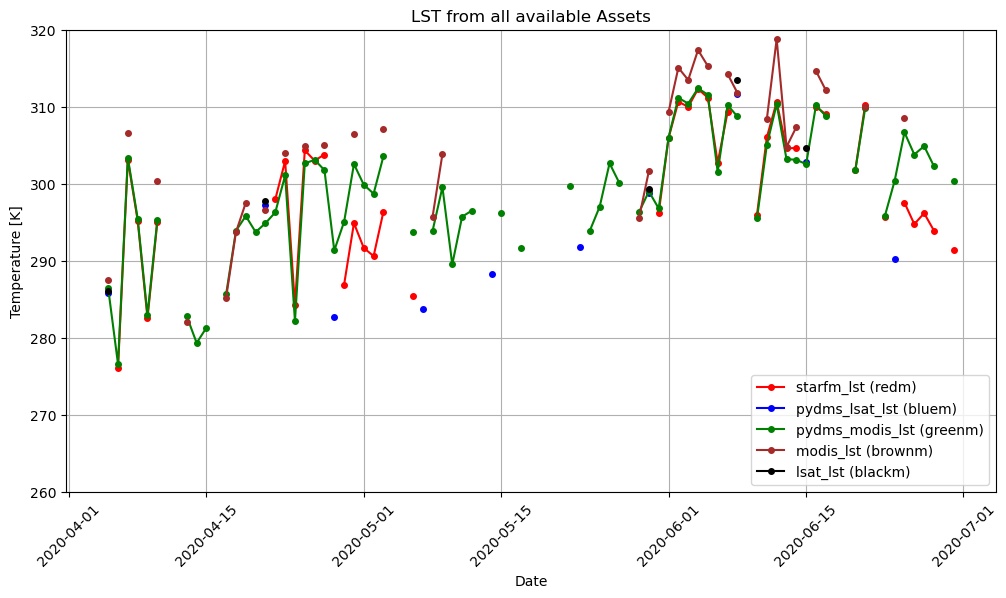

In [130]:
# Now plot LST and 2mT ----------------------

fig, ax = plt.subplots(figsize=(12, 6))

for i, asset in enumerate(asset_dict):

    ax = (plt.plot(
        master_lst_df.index, master_lst_df[asset_dict[asset][0]], 
        label="{} ({}m)".format(asset_dict[asset][0], asset_dict[asset][3]),
        marker='o', markersize=4, c=asset_dict[asset][3],)
        )

# This may cut off some outlying points.
plt.ylim(260, 320)

plt.title('LST from all available Assets')
plt.grid(True)
plt.ylabel('Temperature [K]')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Get HRRR 2-m Temperature data and put it in it's own dataframe.

In [73]:
# Get the hrrr data.
hrrr = get_hrrr_point_data(lat, lon, start, num_days)

# Convert to dataframe and clean it up.
# Get a dataset of point hrrr and convert to dataframe for easier use.
hrrr_df = hrrr.to_dataframe()

# Make date consistent in format.
hrrr_df.reset_index(inplace=True)
hrrr_df['date'] = pd.to_datetime(hrrr_df['time'].dt.date)

# Set the index to date just like the other dataframes.
hrrr_df.set_index('date', inplace=True)

### Now, we'll calculate CATD for each of the assets and create a new dataframe.

In [131]:
days = pd.date_range(start, end) 
catd_df = pd.DataFrame({'date': days})
catd_df.set_index('date', inplace=True)

for i, asset in enumerate(asset_dict):

    catd_col = "catd_{}".format(asset_dict[asset][0])
    catd_df[catd_col] = master_lst_df[asset_dict[asset][0]].sub(hrrr_df['t2m'])


### Plot the CATD for each asset's LST and HRRR 2m temperature.

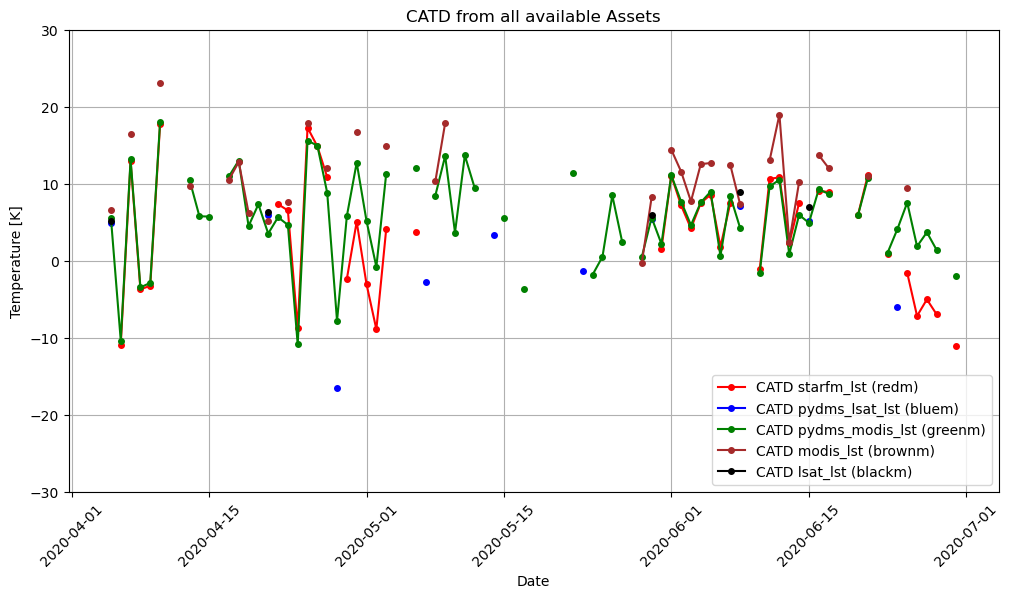

In [133]:
# Now plot CATD  ----------------------

fig, ax = plt.subplots(figsize=(12, 6))

for i, asset in enumerate(asset_dict):

    # This the the name of the columns in the catd df.
    # Just makes it shorter for later use.
    col = "catd_{}".format(asset_dict[asset][0])

    ax = (plt.plot(
        catd_df.index, 
        catd_df[col], 
        label="CATD {} ({}m)".format(asset_dict[asset][0], asset_dict[asset][3]),
        marker='o', markersize=4, c=asset_dict[asset][3]),
        )

# This may cut off some outlying points.
plt.ylim(-30, 30)

plt.title('CATD from all available Assets')
plt.grid(True)
plt.ylabel('Temperature [K]')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### This cell is the main cell for getting NDVI data.
### UNFINISHED
* Surface reflectance is extracted, but need to do the NDVI calcs.

In [127]:
# NDVI collections to search.
# Dictionary keys are: var_name, tolerance, band nir, band red, resolution, plot color.
asset_dict = {
    "prepped_inputs_s2" : ['sentinel2_band', 40, 8, 4, 20, 'red'],
    "prepped_inputs_mcd43a4" : ['modis_band', 1000, 0, 500, 'blue'],
}

# Create new master dataframe to append to
# starting with our full date range.
days = pd.date_range(start, end) 
master_ndvi_df = pd.DataFrame({'date': days})
master_ndvi_df.set_index('date', inplace=True)

for i, asset in enumerate(asset_dict):

    # Search and retrieve images.
    (found_items, num_tiles) = stac_tile_search(asset, geom, start_date, end_date)

    # Extract BAND 2 data.
    (red_time_series_df) = (extract_time_series(
        found_items, bbox, 
        asset_dict[asset][1], asset_dict[asset][0], 
        start_date, end_date, 'surface_reflectance_red'))
    print ("*BAND 2*", red_time_series_df)
    
    # Extract BAND 6 data.
    (nir_time_series_df) = (extract_time_series(
        found_items, bbox, 
        asset_dict[asset][1], asset_dict[asset][0], 
        start_date, end_date, 'surface_reflectance_nir'))
    

    print ("*BAND 6*" , nir_time_series_df)
    
    # Compute NDVI
    col = "ndvi_{}".format(asset_dict[asset][0])
    ndvi = ((nir_time_series_df[asset_dict[asset][0]] - red_time_series_df[asset_dict[asset][0]]) / 
            (nir_time_series_df[asset_dict[asset][0]] + red_time_series_df[asset_dict[asset][0]]))
    
    ndvi_df = ndvi.to_frame()
    
    # Merge each df into master dataframe.
    # Merge on index (date) and keep all rows from both dfs (inner join).
    master_ndvi_df = pd.merge(
        master_ndvi_df, ndvi_df, 
        left_index=True, right_index=True, how = 'outer')

master_ndvi_df

colllection: prepped_inputs_s2 

Number of fusion tiles available: 11
surface_reflectance_red


KeyError: 'surface_reflectance_red'

### Plot the NDVI for each asset.

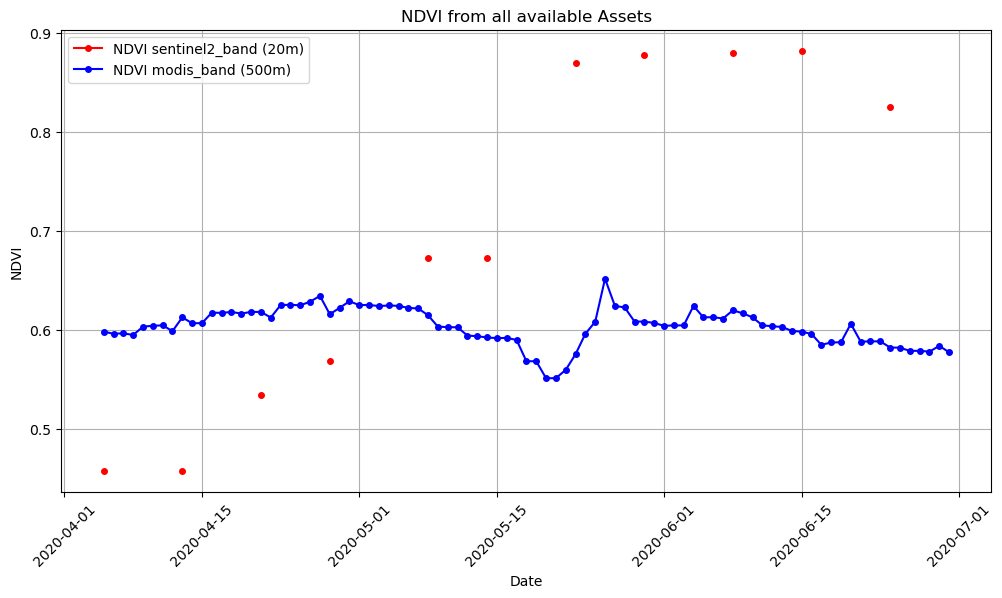

In [121]:
# Now plot NDVI ----------------------
asset_dict = {
    "prepped_inputs_s2" : ['sentinel2_band', 40, 0, 20, 'red'],
    "prepped_inputs_mcd43a4" : ['modis_band', 1000, 0, 500, 'blue'],
}

fig, ax = plt.subplots(figsize=(12, 6))

for i, asset in enumerate(asset_dict):

    ax = (plt.plot(
        master_ndvi_df.index, 
        master_ndvi_df[asset_dict[asset][0]], 
        label="NDVI {} ({}m)".format(asset_dict[asset][0], asset_dict[asset][3]),
        marker='o', markersize=4, c=asset_dict[asset][4]),
        )

plt.title('NDVI from all available Assets')
plt.grid(True)
plt.ylabel('NDVI')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()